# Modelos de Series Temporais LSTM para prever o uso de energia doméstica

Dado o aumento de medidores inteligentes de eletricidade e a ampla adoção de tecnologia de geração de eletricidade, como painéis solares, existem muitos dados disponíveis.

Esses dados representam uma série temporal multivariada de variáveis relacionadas à energia que, por sua vez, podem ser usadas para modelar e até prever o consumo futuro de eletricidade.

Ao contrário de outros algoritmos de aprendizado de máquina, as redes neurais recorrentes de memória de longo prazo são capazes de aprender recursos automaticamente a partir de dados de sequência, suportam dados de várias variáveis e podem produzir sequências de comprimento variável que podem ser usadas para previsões em várias etapas.

Neste exemplo, você descobrirá como desenvolver redes neurais recorrentes de memória de longo prazo para previsão de séries temporais de várias etapas do consumo de energia doméstica.

Depois de concluir este tutorial, você saberá:

- Como desenvolver e avaliar Encoder-Decoder LSTMs univariados e multivariados para previsão de séries temporais.
- Como desenvolver e avaliar um modelo Encoder-Decoder CNN-LSTM para previsão de séries temporais.
- Como desenvolver e avaliar um modelo Encoder-Decoder ConvLSTM para previsão de séries temporais.

Vamos começar.

In [21]:
# Importando os pacotes
import numpy as np 
import pandas as pd 
import scipy as sc
from matplotlib import pyplot
import statsmodels as st
from math import sqrt
import sklearn as sk
from sklearn.metrics import mean_squared_error
from IPython.display import Image

## Overview

Este notebook está dividido em 9 partes:

- Descrição do Problema de Negócio
- Carregando e Preparando os dados
- Avaliação dos Modelos
  - LSTMs for Multi-Step Forecasting
  - LSTM Model With Univariate Input and Vector Output
  - Encoder-Decoder LSTM Model With Univariate Input
  - Encoder-Decoder LSTM Model With Multivariate Input
  - CNN-LSTM Encoder-Decoder Model With Univariate Input
  - ConvLSTM Encoder-Decoder Model With Univariate Input

## O Problema

O conjunto de dados do exemplo é um conjunto de dados multivariado de séries temporais que descreve o consumo de eletricidade para uma única família em quatro anos.

Os dados foram coletados entre dezembro de 2006 e novembro de 2010 e as observações de consumo de energia dentro da residência foram coletadas a cada minuto.

É uma série multivariada composta por sete variáveis (além da data e hora). São eles:

- **global_active_power:** a energia ativa total consumida pela família (kilowatts).
- **global_reactive_power:** a energia reativa total consumida pela família (kilowatts).
- **tensão:** tensão média (volts).
- **global_intensity:** intensidade média atual (amperes).
- **sub_metering_1:** Energia ativa para cozinha (watt-hora de energia ativa).
- **sub_metering_2:** Energia ativa para lavanderia (watt-hora de energia ativa).
- **sub_metering_3:** Energia ativa para sistemas de controle climático (watt-hora de energia ativa).

Energia ativa e reativa referem-se aos detalhes técnicos da corrente alternativa.

## Carregando e Preparando os Dados

O conjunto de dados pode ser baixado do repositório do UCI Machine Learning como um único arquivo .zip de 20 megabytes.

Faça o download do conjunto de dados e descompacte-o em seu diretório de trabalho atual. Agora você terá o arquivo "family_power_consumption.txt", que tem cerca de 127 megabytes de tamanho e contém todas as observações.

Podemos usar a função read_csv() do pacote pandas para carregar os dados e combinar as duas primeiras colunas em uma única coluna de data e hora que podemos usar como índice.

In [2]:
# carregando os dados
dataset = pd.read_csv('data/household_power_consumption.txt', sep=';',header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [3]:
dataset.head()

Global_active_power Global_reactive_power  Voltage  \
datetime                                                                 
2006-12-16 17:24:00               4.216                 0.418  234.840   
2006-12-16 17:25:00               5.360                 0.436  233.630   
2006-12-16 17:26:00               5.374                 0.498  233.290   
2006-12-16 17:27:00               5.388                 0.502  233.740   
2006-12-16 17:28:00               3.666                 0.528  235.680   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
datetime                                                             
2006-12-16 17:24:00           18.400          0.000          1.000   
2006-12-16 17:25:00           23.000          0.000          1.000   
2006-12-16 17:26:00           23.000          0.000          2.000   
2006-12-16 17:27:00           23.000          0.000          1.000   
2006-12-16 17:28:00           15.800          0.000          1.000   

                     Sub_metering_3  
datetime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

Em seguida, podemos marcar todos os valores missing indicados com um caractere '?' com um valor NaN, que é um valor flutuante.

Isso nos permitirá trabalhar com os dados como uma matriz de valores de ponto flutuante em vez de tipos mistos (menos eficiente.)

In [4]:
# Marcando todos os valores missing
dataset.replace('?', np.nan, inplace=True)

# Transformando o dataset para o tipo numerico
dataset = dataset.astype('float32')

Também precisamos preencher os valores missing agora que eles foram marcados.

Uma abordagem muito simples seria copiar a observação da mesma hora do dia anterior. Nós podemos implementar isso em uma função chamada fill_missing() que pegará a matriz NumPy dos dados e copiará os valores exatamente de 24 horas atrás.

In [5]:
# Preenchendo os valores missing com os valores do mesmo horario do dia anterior
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if pd.isnull(values[row, col]):
                values[row, col] = values[row - one_day, col]

In [6]:
# Executando o preenchimento dos valores missing
fill_missing(dataset.values)

Uma quarta variável de submedição pode ser criada subtraindo a soma de três variáveis definidas de submedição da energia ativa total, da seguinte maneira:

- sub_metering_remainder = (global_active_power * 1000 / 60) - (sub_metering_1 + sub_metering_2 + sub_metering_3)

In [7]:
# Adicionando uma nova feature ao dataset
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

In [8]:
# Salvando o dataset atualizado em um arquivo .CSV
dataset.to_csv('data/household_power_consumption.csv')

## Avaliação do Modelo
Nesta seção, consideraremos como podemos desenvolver e avaliar modelos preditivos para o conjunto de dados de energia doméstica.

Esta seção é dividida em quatro partes:

- Entendimento de Problemas
- Métrica de Avaliação
- Conjuntos de treino e teste
- Validação Walk-Forward

## Entendimento de Problemas
Há muitas maneiras de aproveitar e explorar o conjunto de dados de consumo de energia doméstico.

Neste tutorial, usaremos os dados para explorar uma pergunta muito específica:

  - **Dado o consumo recente de energia, qual é o consumo esperado de energia para a próxima semana?**

Isso requer que um modelo preditivo preveja a potência ativa total de cada dia nos próximos sete dias.

Tecnicamente, esse problema é chamado de problema de previsão de séries temporais com várias etapas, dadas as várias etapas da previsão. Um modelo que utiliza várias variáveis de entrada pode ser referido como um modelo de previsão de séries temporais multivariadas com várias etapas.

Um modelo desse tipo pode ser útil dentro do planejamento de despesas da família. Também poderia ser útil no lado da oferta para o planejamento da demanda de eletricidade para uma família específica.

Esse enquadramento do conjunto de dados também sugere que seria útil reduzir a amostra das observações por minuto do consumo de energia para os totais diários. Isso não é necessário, mas faz sentido, uma vez que estamos interessados em energia total por dia.

Podemos conseguir isso facilmente usando a função resample() do pandas. A chamada dessa função com o argumento ‘D‘ permite que os dados carregados indexados por data e hora sejam agrupados por dia (consulte todos os aliases de deslocamento). Podemos então calcular a soma de todas as observações para cada dia e criar um novo conjunto de dados de dados diários de consumo de energia para cada uma das oito variáveis.

In [9]:
# resample dos dados para diario
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()

# Visualizar
print(daily_data.shape)
print(daily_data.head())

# salvar
daily_data.to_csv('data/household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  Global_reactive_power       Voltage  \
datetime                                                               
2006-12-16          1209.176025              34.922001   93552.53125   
2006-12-17          3390.459961             226.005997  345725.31250   
2006-12-18          2203.825928             161.792007  347373.62500   
2006-12-19          1666.193970             150.942001  348479.00000   
2006-12-20          2225.748047             160.998001  348923.62500   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16       5180.799805             0.0           546.0          4926.0   
2006-12-17      14398.599609          2033.0          4187.0         13341.0   
2006-12-18       9247.200195          1063.0          2621.0         14018.0   
2006-12-19       7094.000000           839.0          7602.0          6197.0   
2006-

A execução do exemplo cria um novo conjunto de dados diário de consumo total de energia e salva o resultado em um arquivo separado denominado ‘household_power_consumption_days.csv‘.

Podemos usar isso como o conjunto de dados para ajustar e avaliar modelos preditivos para a resposta do problema.

## Métrica de Avaliação

Uma previsão será composta por sete valores, um para cada dia da semana seguinte.

É comum em problemas de previsão em séries temporais avaliar cada etapa do tempo previsto separadamente. Isso é útil por alguns motivos:

- Para avaliar um lead-time específico (por exemplo, um dia versus três dias).
- Para avaliar modelos em diferentes lead-time (por exemplo, modelos bons em +1 dia versus modelos bons em dias +5).

As unidades da potência total são quilowatts e seria útil ter uma métrica de erro que também estivesse nas mesmas unidades. O erro quadrático médio raiz (RMSE) e o erro absoluto médio (MAE) se enquadram nesta lei, embora o RMSE seja mais comumente usado e será adotado neste tutorial. Ao contrário do MAE, o RMSE é mais punitivo dos erros de previsão.

A métrica de desempenho para esse problema será o RMSE para cada lead-time do dia 1 ao dia 7.

Pode ser útil resumir o desempenho de um modelo usando uma pontuação única para auxiliar na seleção do modelo.

Uma pontuação possível que poderia ser usada seria o RMSE em todos os dias previstos.

A função assessment_forecasts() abaixo implementará esse comportamento e retornará o desempenho de um modelo com base em várias previsões de sete dias.

In [10]:
# avaliar uma ou mais previsões semanais em relação aos valores esperados
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calcular uma pontuação RMSE para cada dia
    for i in range(actual.shape[1]):
        # calcular o MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calcular o RMSE
        rmse = sqrt(mse)
        # guardar
        scores.append(rmse)
    # calcular todo RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

A execução da função retornará primeiro o RMSE geral, independentemente do dia, depois uma matriz de pontuações do RMSE para cada dia.

## Conjuntos de treino e teste

Usaremos os três primeiros anos de dados para treinar modelos preditivos e o último ano para avaliar modelos.

Os dados em um determinado conjunto de dados serão divididos em semanas padrão. São semanas que começam no domingo e terminam no sábado.

Essa é uma maneira realista e útil de enquadrar o modelo, onde é possível prever o consumo de energia para a próxima semana. Também é útil na modelagem, em que os modelos podem ser usados para prever um dia específico (por exemplo, quarta-feira) ou toda a sequência.

Dividiremos os dados em semanas padrão, trabalhando de trás para frente a partir do conjunto de dados de teste.

O último ano dos dados é em 2010 e o primeiro domingo de 2010 foi em 3 de janeiro. Os dados terminam em meados de novembro de 2010 e o sábado final mais próximo é 20 de novembro. Isso fornece 46 semanas de dados de teste.

A primeira e a última linha de dados diários para o conjunto de dados de teste são fornecidas abaixo para confirmação.

In [11]:
daily_data.head(2)

Global_active_power  Global_reactive_power       Voltage  \
datetime                                                               
2006-12-16          1209.176025              34.922001   93552.53125   
2006-12-17          3390.459961             226.005997  345725.31250   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16       5180.799805             0.0           546.0          4926.0   
2006-12-17      14398.599609          2033.0          4187.0         13341.0   

            sub_metering_4  
datetime                    
2006-12-16    14680.933594  
2006-12-17    36946.667969

In [12]:
daily_data.tail(1)

Global_active_power  Global_reactive_power      Voltage  \
datetime                                                              
2010-11-26          1488.104004             120.826004  303487.5625   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2010-11-26       6259.799805          1080.0           385.0          9989.0   

            sub_metering_4  
datetime                    
2010-11-26    13347.733398

Os dados diários começam no final de 2006.

O primeiro domingo do conjunto de dados é 17 de dezembro, que é a segunda linha de dados.

A organização dos dados em semanas padrão fornece 159 semanas padrão completas para o treinamento de um modelo preditivo.

A função split_dataset() abaixo divide os dados diários em conjuntos de treino e teste e organiza cada um em semanas padrão.

In [13]:
# dividir um conjunto de dados univariado em treino e teste
def split_dataset(data):
    # dividido em semanas padrão
    train, test = data[1:-328], data[-328:-6]
    
    # reestruturar em janelas de dados semanais
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    
    return train, test

Podemos testar essa função carregando o conjunto de dados diário e imprimindo a primeira e a última linha de dados dos conjuntos de treino e teste para confirmar se eles correspondem às expectativas acima.

In [14]:
train, test = split_dataset(daily_data.values)

# validando os dados de treino
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])

# validando os dados de teste
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.268
(46, 7, 8)
2083.454 2197.006


A execução do exemplo mostra que, de fato, o conjunto de dados de treino tem 159 semanas de dados, enquanto o conjunto de dados de teste tem 46 semanas.

Podemos ver que a potência ativa total para o conjunto de dados de treino e teste da primeira e da última linha corresponde aos dados das datas específicas que definimos como limites nas semanas padrão de cada conjunto.

## Validação Walk-Forward
Os modelos serão avaliados usando um esquema chamado validação direta.

É aqui que um modelo é necessário para fazer uma previsão de uma semana; em seguida, os dados reais dessa semana são disponibilizados para o modelo, para que possam ser usados como base para fazer uma previsão na semana subseqüente. Isso mostra como o modelo pode ser usado na prática, permitindo que eles utilizem os melhores dados disponíveis.

Podemos demonstrar isso abaixo com a separação dos dados de entrada e dos dados de saída / previstos.

A abordagem de validação passo a passo para avaliar modelos preditivos nesse conjunto de dados é fornecida abaixo denominada assessment_model().

Os conjuntos de dados de treino e teste no formato de semana são fornecidos para a função como argumentos. É fornecido um argumento adicional n_input que é usado para definir o número de observações anteriores que o modelo usará como entrada para fazer uma previsão.

Duas novas funções são chamadas: uma para criar um modelo a partir dos dados de treino chamados build_model() e outra que usa o modelo para fazer previsões para cada nova semana, chamada forecast().

Estamos trabalhando com redes neurais e, como tal, geralmente são lentas para treinar, mas rápidas para avaliar. Isso significa que o uso preferido dos modelos é construí-los uma vez com dados históricos e usá-los para prever cada etapa da validação direta. Os modelos são estáticos (ou seja, não são atualizados) durante sua avaliação.

Isso é diferente de outros modelos que são mais rápidos de treinar, onde um modelo pode ser reajustado ou atualizado a cada etapa da validação progressiva à medida que novos dados são disponibilizados. Com recursos suficientes, é possível usar redes neurais dessa maneira, mas não o usaremos neste tutorial.

A função completa assessment_model() está listada abaixo.

In [15]:
# avaliar um único modelo
def evaluate_model(train, test, n_input):
    # fit do modelo
    model = build_model(train, n_input)
    
    # history é uma lista de dados semanais
    history = [x for x in train]
    
    # validacao walk-forward para cada semana
    predictions = list()
    for i in range(len(test)):
        # prevendo a semana
        yhat_sequence = forecast(model, history, n_input)
        
        # armazenar as previsoes 
        predictions.append(yhat_sequence)
        
        # obter observação real e adicionar ao histórico para prever a próxima semana
        history.append(test[i, :])
    
    # avaliar previsões para cada semana
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

Depois de termos a avaliação de um modelo, podemos resumir o desempenho.

A função abaixo chamada summarize_scores() exibirá o desempenho de um modelo como uma única linha para facilitar a comparação com outros modelos.

In [16]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

Agora temos todos os elementos para começar a avaliar modelos preditivos no conjunto de dados.

## LSTMs para Multi-Step Forecasting
As redes neurais recorrentes, ou RNNs, são projetadas especificamente para trabalhar, aprender e prever dados de sequência.

Uma rede neural recorrente é uma rede neural em que a saída da rede de uma etapa de tempo é fornecida como uma entrada na etapa de tempo subsequente. Isso permite que o modelo tome uma decisão sobre o que prever com base na entrada para a etapa de tempo atual e no conhecimento direto do que foi produzido na etapa de tempo anterior.

Talvez o RNN mais bem sucedida e amplamente utilizada seja a rede de memória de longo prazo, ou LSTM, para abreviar. É bem-sucedida porque supera os desafios envolvidos no treinamento de uma rede neural recorrente, resultando em modelos estáveis. Além de aproveitar a conexão recorrente das saídas da etapa anterior, os LSTMs também possuem uma memória interna que opera como uma variável local, permitindo que eles acumulem estado na sequência de entrada.

LSTMs oferecem vários benefícios quando se trata de previsão de séries temporais:

- **Suporte nativo para sequências:** Os LSTMs são um tipo de rede recorrente e, como tal, são projetados para receber dados de sequência como entrada, ao contrário de outros modelos em que as observações de atraso devem ser apresentadas como recursos de entrada.
- **Entradas multivariadas:** Os LSTMs suportam diretamente várias seqüências de entradas paralelas para entradas multivariadas, ao contrário de outros modelos em que as entradas multivariadas são apresentadas em uma estrutura plana.
- **Saída de vetor:** Como outras redes neurais, os LSTMs são capazes de mapear dados de entrada diretamente para um vetor de saída que pode representar várias etapas do tempo de saída.

Além disso, foram desenvolvidas arquiteturas especializadas que são projetadas especificamente para fazer previsões de sequência com várias etapas, geralmente chamadas de previsão de sequência a sequência, ou seq2seq, resumidamente. Isso é útil, pois a previsão de séries temporais com várias etapas é um tipo de previsão seq2seq.

Um exemplo de uma arquitetura de rede neural recorrente projetada para problemas seq2seq é o encoder-decoder LSTM.

Um encoder-decoder LSTM é um modelo composto por dois submodelos: um chamado codificador que lê as seqüências de entrada e o compacta em uma representação interna de comprimento fixo e um modelo de saída chamado decodificador que interpreta a representação interna e a utiliza para prever a sequência de saída.

A abordagem encoder-decoder para predição de sequência provou ser muito mais eficaz do que a saída direta de um vetor e é a abordagem preferida.

Geralmente, os LSTMs não são muito eficazes em problemas do tipo de auto-regressão. Esses são problemas nos quais a previsão da próxima etapa é uma função das etapas recentes.

As redes neurais convolucionais unidimensionais, ou CNNs, provaram ser eficazes no aprendizado automático de recursos a partir de seqüências de entrada.

Uma abordagem popular tem sido combinar CNNs com LSTMs, onde a CNN é um codificador para aprender recursos de sub-sequências de dados de entrada que são fornecidas como etapas de tempo para um LSTM. Essa arquitetura é chamada de CNN-LSTM.

Uma variação de potência na arquitetura CNN LSTM é o ConvLSTM que usa a leitura convolucional das subsequências de entrada diretamente nas unidades de um LSTM. Essa abordagem se mostrou muito eficaz para a classificação de séries temporais e pode ser adaptada para uso em previsões de séries temporais com várias etapas.

Neste tutorial, exploraremos um conjunto de arquiteturas LSTM para previsão de séries temporais em várias etapas. Especificamente, veremos como desenvolver os seguintes modelos:

- **LSTM** com saída vetorial para previsão em várias etapas com dados de entrada univariados.
- **Encoder-Decoder LSTM** para previsão em várias etapas com dados de entrada univariados.
- **Encoder-Decoder LSTM** para previsão em várias etapas com dados de entrada multivariados.
- **CNN-LSTM Encoder-Decoder** para previsão em várias etapas com dados de entrada univariados.
- **ConvLSTM Encoder-Decoder** para previsão em várias etapas com dados de entrada univariados.

Os modelos serão desenvolvidos e demonstrados sobre o problema de previsão de energia doméstica. Um modelo é considerado hábil se obtiver desempenho melhor do que um modelo simples, que é um RMSE geral de cerca de 465 quilowatts em uma previsão de sete dias.

Não focaremos no ajuste desses modelos para obter o desempenho ideal; em vez disso, pararemos em modelos habilidosos em comparação com uma previsão simples. As estruturas e hiperparâmetros escolhidos são escolhidos com um pouco de tentativa e erro. As pontuações devem ser tomadas apenas como exemplo, e não como um estudo do modelo ou configuração ideal para o problema.

Dada a natureza estocástica dos modelos, é uma boa prática avaliar um determinado modelo várias vezes e relatar o desempenho médio em um conjunto de dados de teste. No interesse da brevidade e da manutenção do código simples, apresentaremos execuções únicas de modelos neste tutorial.

Não podemos saber qual abordagem será a mais eficaz para um determinado problema de previsão em várias etapas. É uma boa idéia explorar um conjunto de métodos para descobrir o que funciona melhor em seu conjunto de dados específico.

## LSTM com entrada univariada e saída vetorial
Começaremos desenvolvendo um modelo LSTM simples que lê uma sequência de dias de consumo de energia diário e prevê uma saída vetorial da próxima semana de consumo diário de energia.

Isso fornecerá a base para os modelos mais elaborados desenvolvidos nas seções subseqüentes.

O número de dias anteriores usado como entrada define a subsequência unidimensional (1D) dos dados que o LSTM lerá e aprenderá a extrair recursos. Algumas ideias sobre o tamanho e a natureza dessa entrada incluem:

- Todos os dias anteriores, até anos de dados.
- Os sete dias anteriores.
- As duas semanas anteriores.
- O mês anterior.
- O ano anterior.
- A semana anterior e a semana a ser prevista em um ano atrás.

Não há resposta correta; em vez disso, cada abordagem pode ser testada e o desempenho do modelo pode ser usado para escolher a natureza da entrada que resulta no melhor desempenho do modelo.

Essas opções definem algumas coisas:

- Como os dados de treinamento devem ser preparados para se ajustar ao modelo.
- Como os dados de teste devem ser preparados para avaliar o modelo.
- Como usar o modelo para fazer previsões com um modelo final no futuro.

Um bom ponto de partida seria usar os sete dias anteriores.

Um modelo LSTM espera que os dados tenham a forma:

**[samples, timesteps, features]**

Uma amostra será composta por sete etapas de tempo com um recurso para os sete dias de energia diária consumida.

O conjunto de dados de treinamento possui 159 semanas de dados, portanto, a forma do conjunto de dados de treinamento seria:

**[159, 7, 1]**

Este é um bom começo. Os dados nesse formato usariam a semana anterior para prever a próxima semana. Um problema é que 159 instâncias não são muito para treinar uma rede neural.

Uma maneira de criar muito mais dados de treinamento é alterar o problema durante o treinamento para prever os próximos sete dias, dados os sete dias anteriores, independentemente da semana.

Isso afeta apenas os dados de treinamento e o problema do teste permanece o mesmo: prever o consumo diário de energia para a próxima semana padrão, dada a semana padrão anterior.

Isso exigirá uma pequena preparação dos dados de treinamento.

Os dados de treinamento são fornecidos em semanas com oito variáveis, especificamente na forma [159, 7, 8]. O primeiro passo é achatar os dados para termos oito seqüências de séries temporais.

Precisamos, então, repetir as etapas do tempo e dividir os dados em janelas sobrepostas; cada iteração se move ao longo de uma etapa e prevê os sete dias subsequentes.

Por exemplo:

Podemos fazer isso acompanhando os índices inicial e final das entradas e saídas à medida que iteramos pelo comprimento dos dados achatados em termos de etapas de tempo.

Também podemos fazer isso de uma maneira em que o número de entradas e saídas seja parametrizado (por exemplo, n_input, n_out) para que você possa experimentar valores diferentes ou adaptá-lo para seu próprio problema.

Abaixo está uma função chamada to_supervised() que leva uma lista de semanas (histórico) e o número de etapas a serem usadas como entradas e saídas e retorna os dados no formato de janela em movimento sobreposto.

In [17]:
# converter histórico em entradas e saídas
def to_supervised(train, n_input, n_out=7):
    # flatten dos dados
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    
    # percorrer toda a história um passo de cada vez
    for _ in range(len(data)):
        # definir o final da sequência de entrada
        in_end = in_start + n_input
        out_end = in_end + n_out
        
        # verifique se temos dados suficientes para esta instância
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        
        # avançar um passo
        in_start += 1
    return np.array(X), np.array(y)

Quando executamos essa função em todo o conjunto de dados de treino, transformamos 159 amostras em 1.100; o conjunto de dados transformado tem as formas X = [1100, 7, 1] e y = [1100, 7].

Em seguida, podemos definir e ajustar o modelo LSTM nos dados de treino.

Esse problema de previsão de séries temporais é uma regressão automática. Isso significa que provavelmente é melhor modelado onde os próximos sete dias são função das observações em etapas anteriores. Isso e a quantidade relativamente pequena de dados significa que é necessário um modelo pequeno.

Vamos desenvolver um modelo com uma única camada LSTM oculta com 200 unidades. O número de unidades na camada oculta não está relacionado ao número de etapas de tempo nas seqüências de entrada. A camada LSTM é seguida por uma camada totalmente conectada com 200 nós que interpretam os recursos aprendidos pela camada LSTM. Finalmente, uma camada de saída preverá diretamente um vetor com sete elementos, um para cada dia na sequência de saída.

Usaremos a função de perda de erro quadrático médio, pois é uma boa combinação para a métrica de erro escolhida para o RMSE. Usaremos o otimizador Adam da descida do gradiente estocástico e ajustaremos o modelo para 70 épocas com um tamanho de lote de 16.

O tamanho pequeno do lote e a natureza estocástica do algoritmo significa que o mesmo modelo aprenderá um mapeamento ligeiramente diferente de entradas para saídas sempre que for treinado. Isso significa que os resultados podem variar quando o modelo é avaliado. Você pode tentar executar o modelo várias vezes e calcular uma média de desempenho do modelo.

O build_model() abaixo prepara, define e ajusta o modelo, retornando as previsões.

In [18]:
# Funcao para treinamento do modelo
def build_model(train, n_input):
    # preparacao dos dados
    train_x, train_y = to_supervised(train, n_input)
    
    # definindo os parametros do modelo
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    # construindo o modelo LSTM
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    
    # fit do modelo
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

Agora que sabemos como ajustar o modelo, podemos ver como o modelo pode ser usado para fazer uma previsão.

Geralmente, o modelo espera que os dados tenham a mesma forma tridimensional ao fazer uma previsão.

Nesse caso, a forma esperada de um padrão de entrada é uma amostra, sete dias de um recurso para a energia diária consumida:

**[1, 7, 1]**

Os dados devem ter esse formato ao fazer previsões para o conjunto de testes e quando um modelo final estiver sendo usado para fazer previsões no futuro. Se você alterar o número de dias de entrada para 14, o formato dos dados de treinamento e o formato de novas amostras ao fazer previsões deverão ser alterados adequadamente para ter 14 etapas de tempo. É uma opção de modelagem que você deve levar adiante ao usar o modelo.

Estamos usando a validação direta para avaliar o modelo conforme descrito na seção anterior.

Isso significa que temos as observações disponíveis para a semana anterior, a fim de prever a próxima semana. Eles são coletados em uma série de semanas chamada história.

Para prever a próxima semana, precisamos recuperar os últimos dias de observações. Assim como os dados de treinamento, precisamos primeiro achatar os dados do histórico para remover a estrutura semanal, para terminar com oito séries temporais paralelas.

Em seguida, precisamos recuperar os últimos sete dias da energia total diária consumida (índice de recurso 0).

Parametrizaremos isso como fizemos para os dados de treinamento, para que o número de dias anteriores usado como entrada pelo modelo possa ser modificado no futuro.

Em seguida, reformulamos a entrada na estrutura tridimensional esperada.

Em seguida, fazemos uma previsão usando o modelo de ajuste e os dados de entrada e recuperamos o vetor de sete dias de saída.

A função forecast() abaixo implementa isso e assume como argumentos o modelo ajustado no conjunto de dados de treinamento, o histórico de dados observados até o momento e o número de etapas de tempo de entrada esperadas pelo modelo.

In [19]:
# realizando previsoes
def forecast(model, history, n_input):
    # flatten dos dados
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    # recuperar últimas observações para dados de entrada
    input_x = data[-n_input:, 0]
    
    # reshape [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    
    # previsao da proxima semana
    yhat = model.predict(input_x, verbose=0)
    
    # queremos apenas a previsão do vetor
    yhat = yhat[0]
    return yhat

É isso aí; agora temos tudo o que precisamos para fazer previsões de séries temporais com várias etapas, com um modelo LSTM no conjunto de dados univariado diário de energia total consumida.

Abaixo a execução e avaliação do modelo, imprimindo o RMSE geral nos sete dias e o RMSE diário para cada lead time.

lstm: [396.533] 398.1, 411.3, 371.1, 377.8, 399.1, 320.7, 480.1


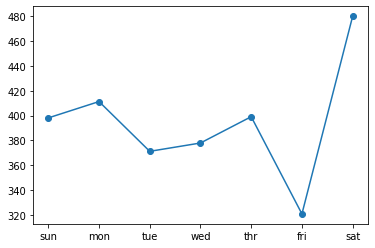

In [23]:
# LSTM com entrada univariada e saída vetorial
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

# dividir os dados em conjuntos de treino/teste
def split_dataset(data):
    # split em semanas
    train, test = data[1:-328], data[-328:-6]
    # reestruturar em janelas de dados semanais
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# avaliar uma ou mais previsões semanais em relação aos valores esperados
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calcular uma pontuação RMSE para cada dia
    for i in range(actual.shape[1]):
        # calcular MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calcular RMSE
        rmse = sqrt(mse)
        # armazenar
        scores.append(rmse)
    # calcular RMSE geral
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# converter histórico em entradas e saídas
def to_supervised(train, n_input, n_out=7):
    # achatamento dos dados
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # percorrer toda a história um passo de cada vez
    for _ in range(len(data)):
        # definir o final da sequência de entrada
        in_end = in_start + n_input
        out_end = in_end + n_out
        # verifique se temos dados suficientes para esta instância
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # avançar um passo
        in_start += 1
    return array(X), array(y)

# treinamento do modelo
def build_model(train, n_input):
    # preparacao dos dados
    train_x, train_y = to_supervised(train, n_input)
    # definicao dos parametros
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # definicao do modelo
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit do modelo
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# fazendo as previsoes
def forecast(model, history, n_input):
    # achatamento dos dados
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # recuperar últimas observações para dados de entrada
    input_x = data[-n_input:, 0]
    # reshape [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # prever a próxima semana
    yhat = model.predict(input_x, verbose=0)
    # buscando apenas a previsão do vetor
    yhat = yhat[0]
    return yhat

# avaliar o modelo
def evaluate_model(train, test, n_input):
    # fit do modelo
    model = build_model(train, n_input)
    # história é uma lista de dados semanais
    history = [x for x in train]
    # validacao walk-forward para cada semana
    predictions = list()
    for i in range(len(test)):
        # previsao da semana
        yhat_sequence = forecast(model, history, n_input)
        # gravar as previsoes
        predictions.append(yhat_sequence)
        # obter observação real e adicionar ao histórico para prever a próxima semana
        history.append(test[i, :])
    # avaliar as previsões para cada semana
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

# carrega o arquivo já ajustado
dataset = read_csv('data/household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

# split dos dados em treino e teste
train, test = split_dataset(dataset.values)

# validacao do modelo
n_input = 7
score, scores = evaluate_model(train, test, n_input)

# summarize scores
summarize_scores('lstm', score, scores)

# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

Seus resultados específicos podem variar de acordo com a natureza estocástica do algoritmo. Você pode tentar executar o exemplo algumas vezes.

Podemos ver que, neste caso, o modelo é bom em comparação com uma previsão simples, atingindo um RMSE geral de cerca de 396 quilowatts, menos de 465 quilowatts atingidos por um modelo simples.

O gráfico mostra que talvez as terças e sextas-feiras sejam dias mais fáceis de prever do que nos outros dias e que talvez o sábado no final da semana seja o dia mais difícil de prever.

Podemos aumentar o número de dias anteriores para usar como entrada de 7 para 14, alterando a variável n_input.

lstm: [385.205] 382.2, 396.0, 355.8, 398.5, 374.4, 298.9, 470.0


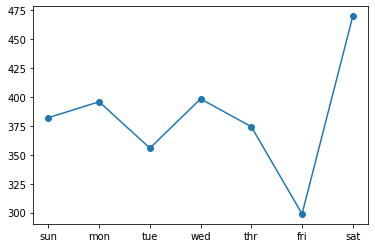

In [24]:
# avaliar modelo e obter score
n_input = 14
score, scores = evaluate_model(train, test, n_input)

# summarize scores
summarize_scores('lstm', score, scores)

# plot dos scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

Nesse caso, podemos ver uma queda adicional no RMSE geral para cerca de 385 quilowatts, sugerindo que ajustes adicionais no tamanho da entrada e talvez o número de nós no modelo possam resultar em melhor desempenho.

## Encoder-Decoder LSTM com entrada univariada
Nesta seção, podemos atualizar o LSTM para usar um modelo de Encoder-Decoder.

Isso significa que o modelo não produzirá uma sequência vetorial diretamente. Em vez disso, o modelo será composto de dois submodelos, o codificador para ler e codificar a sequência de entrada e o decodificador que lerá a sequência de entrada codificada e fará uma previsão em uma etapa para cada elemento na sequência de saída.

A diferença é sutil, pois, na prática, as duas abordagens de fato prevêem uma saída de sequência.

A diferença importante é que um modelo LSTM é usado no decodificador, permitindo que ele saiba o que foi previsto para o dia anterior na sequência e acumule o estado interno enquanto produz a sequência.

Vamos dar uma olhada em como este modelo é definido.

In [25]:
# Treinamento do modelo
def build_model(train, n_input):
    # preparacao dos dados
    train_x, train_y = to_supervised(train, n_input)
    
    # definir parâmetros
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    # reshape output [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    # definindo o modelo
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    # fit da rede
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

Como antes, definimos uma camada oculta LSTM com 200 unidades. Este é o modelo do decodificador que lerá a sequência de entrada e produzirá um vetor de 200 elementos (uma saída por unidade) que captura recursos da sequência de entrada. Usaremos 14 dias de consumo total de energia como entrada.

Usaremos uma arquitetura simples de codificador-decodificador que é fácil de implementar no Keras, que tem muita semelhança com a arquitetura de um autoencoder LSTM.

Primeiro, a representação interna da sequência de entrada é repetida várias vezes, uma vez para cada etapa do tempo na sequência de saída. Esta sequência de vetores será apresentada ao decodificador LSTM.

Em seguida, definimos o decodificador como uma camada oculta LSTM com 200 unidades. É importante ressaltar que o decodificador produzirá a sequência inteira, não apenas a saída no final da sequência, como fizemos com o codificador. Isso significa que cada uma das 200 unidades produzirá um valor para cada um dos sete dias, representando a base do que prever para cada dia na sequência de saída.

Após esse processo, usaremos uma camada totalmente conectada para interpretar cada etapa do tempo na sequência de saída antes da camada de saída final. É importante ressaltar que a camada de saída prevê uma única etapa na sequência de saída, nem todos os sete dias de cada vez. Isso significa que usaremos as mesmas camadas aplicadas a cada etapa na sequência de saída, onde as mesmas camadas de saída totalmente conectadas serão usadas para processar cada etapa do tempo fornecida pelo decodificador. Para conseguir isso, envolveremos a camada de interpretação e a camada de saída em um  'TimeDistributed wrapper' que permite que as camadas envolvidas sejam usadas para cada etapa do decodificador.

Isso permite que o decodificador LSTM descubra o contexto necessário para cada etapa na sequência de saída e as camadas densas envolvidas para interpretar cada etapa separadamente, mas reutilizando os mesmos pesos para executar a interpretação. Uma alternativa seria achatar toda a estrutura criada pelo decodificador LSTM e gerar o vetor diretamente. Você pode tentar isso como uma extensão para ver como ele se compara.

A rede, portanto, gera um vetor tridimensional com a mesma estrutura que a entrada, com as dimensões [amostras, etapas de tempo, recursos].

Há um único recurso, a energia total diária consumida e sempre existem sete recursos. Uma única previsão de uma semana terá, portanto, o tamanho: [1, 7, 1].

Portanto, ao treinar o modelo, devemos reestruturar os dados de saída (y) para ter a estrutura tridimensional em vez da estrutura bidimensional de [amostras, recursos] usada na seção anterior.

lstm: [389.434] 401.3, 404.4, 347.8, 377.5, 376.7, 301.3, 490.8


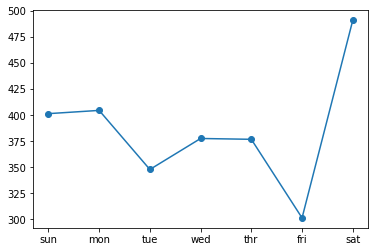

In [26]:
# Encoder-Decoder LSTM com entrada univariada
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

# dividir os dados em conjuntos de treino/teste
def split_dataset(data):
    # split em semanas
    train, test = data[1:-328], data[-328:-6]
    # reestruturar em janelas de dados semanais
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# avaliar uma ou mais previsões semanais em relação aos valores esperados
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calcular uma pontuação RMSE para cada dia
    for i in range(actual.shape[1]):
        # calcular MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calcular RMSE
        rmse = sqrt(mse)
        # armazenar
        scores.append(rmse)
    # calcular RMSE geral
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# converter histórico em entradas e saídas
def to_supervised(train, n_input, n_out=7):
    # achatamento dos dados
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # percorrer toda a história um passo de cada vez
    for _ in range(len(data)):
        # definir o final da sequência de entrada
        in_end = in_start + n_input
        out_end = in_end + n_out
        # verifique se temos dados suficientes para esta instância
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # avançar um passo
        in_start += 1
    return array(X), array(y)

# Treinamento do modelo
def build_model(train, n_input):
    # preparacao dos dados
    train_x, train_y = to_supervised(train, n_input)
    # definir parâmetros
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # definindo o modelo
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit da rede
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# fazendo as previsoes
def forecast(model, history, n_input):
    # achatamento dos dados
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # recuperar últimas observações para dados de entrada
    input_x = data[-n_input:, 0]
    # reshape [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # prever a próxima semana
    yhat = model.predict(input_x, verbose=0)
    # buscando apenas a previsão do vetor
    yhat = yhat[0]
    return yhat

# avaliar o modelo
def evaluate_model(train, test, n_input):
    # fit do modelo
    model = build_model(train, n_input)
    # história é uma lista de dados semanais
    history = [x for x in train]
    # validacao walk-forward para cada semana
    predictions = list()
    for i in range(len(test)):
        # previsao da semana
        yhat_sequence = forecast(model, history, n_input)
        # gravar as previsoes
        predictions.append(yhat_sequence)
        # obter observação real e adicionar ao histórico para prever a próxima semana
        history.append(test[i, :])
    # avaliar as previsões para cada semana
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

# carrega o arquivo já ajustado
dataset = read_csv('data/household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

# split dos dados em treino e teste
train, test = split_dataset(dataset.values)

# validacao do modelo
n_input = 14
score, scores = evaluate_model(train, test, n_input)

# summarize scores
summarize_scores('lstm', score, scores)

# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

O gráfico mostra que esse modelo parece menos estável que o caso univariado e pode estar relacionado às diferentes escalas das oito variáveis de entrada.

Seus resultados específicos podem variar de acordo com a natureza estocástica do algoritmo. Você pode tentar executar o exemplo algumas vezes.

Podemos ver que, nesse caso, o modelo atingiu uma pontuação geral no RMSE de cerca de 390 quilowatts.

## Encoder-Decoder LSTM com entrada multivariada

Nesta seção, atualizaremos o Encoder-Decoder LSTM desenvolvido na seção anterior para usar cada uma das oito variáveis de série temporal e prever a próxima semana do consumo total diário de energia.

Faremos isso fornecendo cada série temporal unidimensional ao modelo como uma sequência separada de entrada.

O LSTM, por sua vez, criará uma representação interna de cada sequência de entrada que será interpretada em conjunto pelo decodificador.

O uso de entradas multivariadas é útil para os problemas em que a sequência de saída é alguma função das observações em etapas anteriores de vários recursos diferentes, não apenas (ou incluindo) o recurso que está sendo previsto. Não está claro se esse é o caso do problema do consumo de energia, mas podemos explorá-lo.

Primeiro, precisamos atualizar a preparação dos dados de treinamento para incluir todos os oito recursos, não apenas a energia diária total consumida. Requer uma única alteração de linha:

**X.append(data[in_start:in_end, :])**

Também devemos atualizar a função usada para fazer previsões com o modelo de ajuste para usar todos os oito recursos das etapas anteriores.

Mais uma vez, outra pequena mudança:

**input_x = data[-n_input:, :]**

**input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))**

A mesma arquitetura e configuração de modelo é usada diretamente, embora aumentaremos o número de épocas de treinamento de 20 para 50, devido ao aumento de 8 vezes na quantidade de dados de entrada.

Abaixo está o código completo estão as alterações nas funções mencionadas:

lstm: [375.096] 381.8, 386.3, 347.8, 383.5, 361.1, 336.2, 422.4


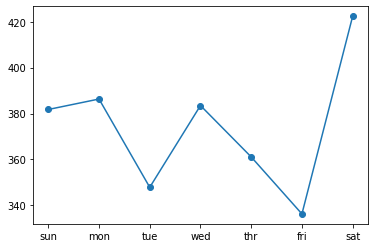

In [27]:
# Encoder-Decoder LSTM com entrada multivariada
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
 
# dividir os dados em conjuntos de treino/teste
def split_dataset(data):
    # split em semanas
    train, test = data[1:-328], data[-328:-6]
    # reestruturar em janelas de dados semanais
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test
 
# avaliar uma ou mais previsões semanais em relação aos valores esperados
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calcular uma pontuação RMSE para cada dia
    for i in range(actual.shape[1]):
        # calcular MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calcular RMSE
        rmse = sqrt(mse)
        # armazenar
        scores.append(rmse)
    # calcular RMSE geral
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# converter histórico em entradas e saídas
def to_supervised(train, n_input, n_out=7):
    # achatamento dos dados
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # percorrer toda a história um passo de cada vez
    for _ in range(len(data)):
        # definir o final da sequência de entrada
        in_end = in_start + n_input
        out_end = in_end + n_out
        # verifique se temos dados suficientes para esta instância
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # avançar um passo
        in_start += 1
    return array(X), array(y)
 
# treinamento do modelo
def build_model(train, n_input):
    # preparacao dos dados
    train_x, train_y = to_supervised(train, n_input)
    # definicao dos parametros
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape da saida [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # definicao do modelo
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit do modelo
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model
 
# fazendo as previsoes
def forecast(model, history, n_input):
    # achatamento dos dados
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # recuperar últimas observações para dados de entrada
    input_x = data[-n_input:, :]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # prever a próxima semana
    yhat = model.predict(input_x, verbose=0)
    # buscando apenas a previsão do vetor
    yhat = yhat[0]
    return yhat
 
# avaliar o modelo
def evaluate_model(train, test, n_input):
    # fit do modelo
    model = build_model(train, n_input)
    # história é uma lista de dados semanais
    history = [x for x in train]
    # validacao walk-forward para cada semana
    predictions = list()
    for i in range(len(test)):
        # previsao da semana
        yhat_sequence = forecast(model, history, n_input)
        # gravar as previsoes
        predictions.append(yhat_sequence)
        # obter observação real e adicionar ao histórico para prever a próxima semana
        history.append(test[i, :])
    # avaliar as previsões para cada semana
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores
 
# carrega o arquivo já ajustado
dataset = read_csv('data/household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

# split dos dados em treino e teste
train, test = split_dataset(dataset.values)

# validacao do modelo
n_input = 14
score, scores = evaluate_model(train, test, n_input)

# summarize scores
summarize_scores('lstm', score, scores)

# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

O resultado constatou que esse modelo parece menos estável que o caso univariado e pode estar relacionado às diferentes escalas das oito variáveis de entrada.

Seus resultados específicos podem variar de acordo com a natureza estocástica do algoritmo. Você pode tentar executar o exemplo algumas vezes.

Podemos ver que, nesse caso, o modelo está atingindo uma pontuação geral no RMSE de cerca de 375 quilowatts.

## Modelo CNN-LSTM Encoder-Decoder com entrada univariada

Uma rede neural convolucional, ou CNN, pode ser usada como codificador em uma arquitetura codificador-decodificador.

A CNN não suporta diretamente a entrada de sequência; em vez disso, uma CNN 1D é capaz de ler as entradas da sequência e aprender automaticamente os recursos mais importantes. Estes podem ser interpretados por um decodificador LSTM como normalmente. Nos referimos a modelos híbridos que usam CNN e LSTM como modelos CNN-LSTM e, neste caso, os estamos usando juntos em uma arquitetura de codificador-decodificador.

A CNN espera que os dados de entrada tenham a mesma estrutura 3D do modelo LSTM, embora vários recursos sejam lidos como canais diferentes que acabam tendo o mesmo efeito.

Simplificaremos o exemplo e focaremos no CNN-LSTM com entrada univariada, mas ele pode ser facilmente atualizado com o uso de entrada multivariada.

Como antes, usaremos sequências de entrada compostas por 14 dias de consumo total diário de energia.

Definiremos uma arquitetura CNN simples, porém eficaz, para o codificador que é composto por duas camadas convolucionais, seguidas por uma camada de max pooling, cujos resultados são então achatados.

A primeira camada convolucional lê a sequência de entrada e projeta os resultados nos mapas de recursos. O segundo executa a mesma operação nos mapas de recursos criados pela primeira camada, tentando amplificar quaisquer recursos salientes. Usaremos 64 features por camada convolucional e leremos as seqüências de entrada com um tamanho de kernel de três etapas de tempo.

A camada de Max Pooling simplifica as features, mantendo 1/4 dos valores com o maior sinal (máximo). As features mapeadas após a camada de max pooling são então achatados em um vetor longo que pode ser usado como entrada no processo de decodificação.

Abaixo a função build_model() com as mudanças:

In [28]:
# função de treinamento do modelo
def build_model(train, n_input):
    # preparacao dos dados
    train_x, train_y = to_supervised(train, n_input)
    
    # definicao dos parametros
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    # reshape [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    # definicao da estrutura do modelo
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    # fit da rede
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

Agora estamos prontos para testar a arquitetura codificador-decodificador com um CNN encoder.

Abaixo o código completo:

lstm: [383.350] 394.3, 381.4, 333.0, 390.2, 372.0, 316.4, 475.5


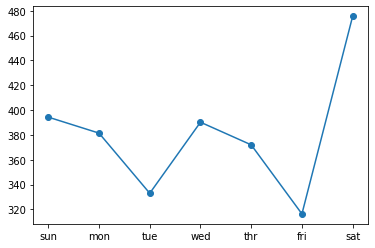

In [31]:
# CNN-LSTM encoder-decoder univariado em várias camadas
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
 
# dividir os dados em conjuntos de treino/teste
def split_dataset(data):
    # split em semanas
    train, test = data[1:-328], data[-328:-6]
    # reestruturar em janelas de dados semanais
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test
 
# avaliar uma ou mais previsões semanais em relação aos valores esperados
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calcular uma pontuação RMSE para cada dia
    for i in range(actual.shape[1]):
        # calcular MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calcular RMSE
        rmse = sqrt(mse)
        # armazenar
        scores.append(rmse)
    # calcular RMSE geral
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# converter histórico em entradas e saídas
def to_supervised(train, n_input, n_out=7):
    # achatamento dos dados
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # percorrer toda a história um passo de cada vez
    for _ in range(len(data)):
        # definir o final da sequência de entrada
        in_end = in_start + n_input
        out_end = in_end + n_out
        # verifique se temos dados suficientes para esta instância
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # avançar um passo
        in_start += 1
    return array(X), array(y)
 
# treinamento do modelo
def build_model(train, n_input):
    # preparacao dos dados
    train_x, train_y = to_supervised(train, n_input)
    # definicao dos parametros
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape da saida [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # definicao do modelo
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit do modelo
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model
 
# fazendo as previsoes
def forecast(model, history, n_input):
    # achatamento dos dados
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # recuperar últimas observações para dados de entrada
    input_x = data[-n_input:, 0]
    input_x = input_x.reshape((1, len(input_x), 1))
    # prever a próxima semana
    yhat = model.predict(input_x, verbose=0)
    # buscando apenas a previsão do vetor
    yhat = yhat[0]
    return yhat
 
# avaliar o modelo
def evaluate_model(train, test, n_input):
    # fit do modelo
    model = build_model(train, n_input)
    # história é uma lista de dados semanais
    history = [x for x in train]
    # validacao walk-forward para cada semana
    predictions = list()
    for i in range(len(test)):
        # previsao da semana
        yhat_sequence = forecast(model, history, n_input)
        # gravar as previsoes
        predictions.append(yhat_sequence)
        # obter observação real e adicionar ao histórico para prever a próxima semana
        history.append(test[i, :])
    # avaliar as previsões para cada semana
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores
 
# carrega o arquivo já ajustado
dataset = read_csv('data/household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

# split dos dados em treino e teste
train, test = split_dataset(dataset.values)

# validacao do modelo
n_input = 14
score, scores = evaluate_model(train, test, n_input)

# summarize scores
summarize_scores('lstm', score, scores)

# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

A execução do exemplo se ajusta ao modelo e resume o desempenho no conjunto de dados de teste.

O resultado mostrou que o uso de duas camadas convolucionais tornou o modelo mais estável do que o uso de apenas uma camada.

Seus resultados específicos podem variar de acordo com a natureza estocástica do algoritmo.

Podemos ver que, nesse caso, o modelo está atingindo uma pontuação geral no RMSE de cerca de 383 quilowatts.

## Modelo ConvLSTM Encoder-Decoder com entrada univariada

Uma outra extensão da abordagem CNN-LSTM é executar as convoluções da CNN (por exemplo, como a CNN lê os dados da sequência de entrada) como parte do LSTM para cada etapa do tempo.

Essa combinação é chamada de LSTM Convolucional, ou ConvLSTM, para abreviar, e como o CNN-LSTM também é usada para dados espaço-temporais.

Ao contrário de um LSTM que lê os dados diretamente para calcular transições de estado internas, e ao contrário do CNN-LSTM que está interpretando a saída dos modelos CNN, o ConvLSTM está usando convoluções diretamente como parte da leitura de entrada nas próprias unidades LSTM.

A biblioteca Keras fornece a classe ConvLSTM2D que suporta o modelo ConvLSTM para dados 2D. Pode ser configurado para previsão de séries temporais multivariadas em 1D.

A classe ConvLSTM2D, por padrão, espera que os dados de entrada tenham a forma:

**[samples, timesteps, rows, cols, channels]**

Onde cada etapa de dados é definida como uma imagem de (linhas * colunas).

Estamos trabalhando com uma sequência unidimensional do consumo total de energia, que podemos interpretar como uma linha com 14 colunas, se assumirmos que estamos usando duas semanas de dados como entrada.

Para o ConvLSTM, isso seria uma leitura única: ou seja, o LSTM leria uma etapa de 14 dias e executaria uma convolução entre essas etapas de tempo.

Isto não é o ideal.

Em vez disso, podemos dividir os 14 dias em duas subsequências com duração de sete dias. O ConvLSTM pode ler as duas etapas de tempo e executar o processo da CNN nos sete dias de dados em cada uma.

Para esse problema, a entrada para o ConvLSTM2D seria, portanto:

**[n, 2, 1, 7, 1]**

Ou:

**Samples:** n, para o número de exemplos no conjunto de dados de treinamento.
**Time:** 2, para as duas subsequências em que dividimos uma janela de 14 dias.
**Rows:** 1, para a forma unidimensional de cada subsequência.
**Columns:** 7, pelos sete dias em cada subsequência.
**Channels:** 1, para o recurso único com o qual estamos trabalhando como entrada.

Você pode explorar outras configurações, como fornecer 21 dias de entrada divididos em três subsequências de sete dias e/ou fornecer todos os oito recursos ou canais como entrada.

Agora podemos preparar os dados para o modelo ConvLSTM2D.

Primeiro, precisamos remodelar o conjunto de dados de treinamento na estrutura esperada de [samples, timesteps, rows, cols, channels].

Podemos então definir o codificador como uma camada oculta do ConvLSTM, seguida por uma camada achatada pronta para decodificação.

O restante do modelo e treinamento é o mesmo. A função build_model() com essas alterações está listada abaixo:

In [ ]:
# treinamento do modelo
def build_model(train, n_steps, n_length, n_input):
    # preparacao dos dados
    train_x, train_y = to_supervised(train, n_input)
    # definicao dos parametros
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape no formato [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape dos dados [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # definicao do modelo
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit do modelo
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

Este modelo espera dados tridimensionais como entrada. Portanto, também devemos atualizar a preparação de uma única amostra na função forecast() ao fazer uma previsão.

In [32]:
# fazendo as previsoes
def forecast(model, history, n_steps, n_length, n_input):
    # achatamento dos dados
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # recuperar últimas observações para dados de entrada
    input_x = data[-n_input:, 0]
    # reshape dos dados [samples, time steps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    # prever a próxima semana
    yhat = model.predict(input_x, verbose=0)
    # buscando apenas a previsão do vetor
    yhat = yhat[0]
    return yhat

Agora, temos todos os elementos para avaliar uma arquitetura de codificador-decodificador para previsão de séries temporais em várias etapas em que um ConvLSTM é usado como codificador.

O exemplo de código completo está listado abaixo:

lstm: [381.449] 398.5, 391.4, 338.9, 379.8, 393.2, 341.2, 420.0


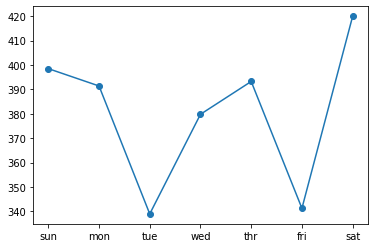

In [34]:
# univariate multi-step encoder-decoder convlstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

# dividir os dados em conjuntos de treino/teste
def split_dataset(data):
    # split em semanas
    train, test = data[1:-328], data[-328:-6]
    # reestruturar em janelas de dados semanais
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# avaliar uma ou mais previsões semanais em relação aos valores esperados
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calcular uma pontuação RMSE para cada dia
    for i in range(actual.shape[1]):
        # calcular MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calcular RMSE
        rmse = sqrt(mse)
        # armazenar
        scores.append(rmse)
    # calcular RMSE geral
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# converter histórico em entradas e saídas
def to_supervised(train, n_input, n_out=7):
    # achatamento dos dados
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # percorrer toda a história um passo de cada vez
    for _ in range(len(data)):
        # definir o final da sequência de entrada
        in_end = in_start + n_input
        out_end = in_end + n_out
        # verifique se temos dados suficientes para esta instância
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # avançar um passo
        in_start += 1
    return array(X), array(y)

# treinamento do modelo
def build_model(train, n_steps, n_length, n_input):
    # preparacao dos dados
    train_x, train_y = to_supervised(train, n_input)
    # definicao dos parametros
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape no formato [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape dos dados [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # definicao do modelo
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit do modelo
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# fazendo as previsoes
def forecast(model, history, n_steps, n_length, n_input):
    # achatamento dos dados
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # recuperar últimas observações para dados de entrada
    input_x = data[-n_input:, 0]
    # reshape dos dados [samples, time steps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    # prever a próxima semana
    yhat = model.predict(input_x, verbose=0)
    # buscando apenas a previsão do vetor
    yhat = yhat[0]
    return yhat

# avaliar o modelo
def evaluate_model(train, test, n_steps, n_length, n_input):
    # fit do modelo
    model = build_model(train, n_steps, n_length, n_input)
    # história é uma lista de dados semanais
    history = [x for x in train]
    # validacao walk-forward para cada semana
    predictions = list()
    for i in range(len(test)):
        # previsao da semana
        yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
        # gravar as previsoes
        predictions.append(yhat_sequence)
        # obter observação real e adicionar ao histórico para prever a próxima semana
        history.append(test[i, :])
    # avaliar as previsões para cada semana
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

# carrega o arquivo já ajustado
dataset = read_csv('data/household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

# split dos dados em treino e teste
train, test = split_dataset(dataset.values)

# definir o número de subsequências e o comprimento das subsequências
n_steps, n_length = 2, 7

# definir o total de dias para usar como entrada
n_input = n_length * n_steps
score, scores = evaluate_model(train, test, n_steps, n_length, n_input)

# summarize scores
summarize_scores('lstm', score, scores)

# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

A execução do exemplo se ajusta ao modelo e resume o desempenho no conjunto de dados de teste.

O gráfico mostra que o uso de duas camadas convolucionais tornou o modelo mais estável do que o uso de apenas uma camada.

Podemos ver que, neste caso, o modelo está atingindo uma pontuação geral no RMSE de cerca de 381 quilowatts.